In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [18]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.regularizers import l2, l1

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [4]:
train_dir = 'data/train/'
test_dir = "data/test/"

os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "Dense201_Xception_Inceptionv3"

In [5]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [6]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [ ]:
# for root,dirs,files in os.walk(train_dir):
#     print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(test_dir):
#     print (root, len(files))

In [7]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [8]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 319152 images belonging to 6 classes.
Found 79784 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [9]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 319152
nb_validation_samples: 79784
nb_test_samples: 13578

predict_size_train: 624
predict_size_validation: 156
predict_size_test: 27

 num_classes: 6


In [ ]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications.inception_v3 import InceptionV3


input_tensor = Input(shape = input_shape)  

base_model1=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=Xception(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

merge = concatenate([x1, x2, x3])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_2
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [12]:
c1 = model.layers[9].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[55].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[143].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[483].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[572].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[586].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[602].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[636].output
c8 = GlobalAveragePooling2D()(c8) 

c9 = model.layers[679].output
c9 = GlobalAveragePooling2D()(c9) 

c10 = model.layers[702].output
c10 = GlobalAveragePooling2D()(c10) 

c11 = model.layers[722].output
c11 = GlobalAveragePooling2D()(c11) 

c12 = model.layers[738].output
c12 = GlobalAveragePooling2D()(c12) 

c13 = model.layers[749].output
c13 = GlobalAveragePooling2D()(c13) 

c14 = model.layers[783].output
c14 = GlobalAveragePooling2D()(c14) 

c15 = model.layers[847].output
c15 = GlobalAveragePooling2D()(c15) 

c16 = model.layers[911].output
c16 = GlobalAveragePooling2D()(c16) 

c17 = model.layers[975].output
c17 = GlobalAveragePooling2D()(c17) 

c18 = model.layers[1042].output
c18 = GlobalAveragePooling2D()(c18) 

c19 = model.layers[1070].output
c19 = GlobalAveragePooling2D()(c19) 

c20 = model.layers[1106].output
c20 = GlobalAveragePooling2D()(c20) 

c21 = model.layers[1125].output
c21 = GlobalAveragePooling2D()(c21) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [19]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.25))

model.add(Dense(256, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.8, beta_2=0.99)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

    
    
top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')    
    
model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 319152 samples, validate on 79784 samples
Epoch 1/1000
 - 17s - loss: 0.6610 - acc: 0.7925 - val_loss: 0.4455 - val_acc: 0.8686
Epoch 2/1000
 - 12s - loss: 0.4391 - acc: 0.8660 - val_loss: 0.3893 - val_acc: 0.8807
Epoch 3/1000
 - 12s - loss: 0.3877 - acc: 0.8812 - val_loss: 0.3516 - val_acc: 0.8928
Epoch 4/1000
 - 12s - loss: 0.3567 - acc: 0.8906 - val_loss: 0.3228 - val_acc: 0.9024
Epoch 5/1000
 - 12s - loss: 0.3359 - acc: 0.8972 - val_loss: 0.3094 - val_acc: 0.9070
Epoch 6/1000
 - 12s - loss: 0.3199 - acc: 0.9027 - val_loss: 0.2999 - val_acc: 0.9093
Epoch 7/1000
 - 12s - loss: 0.3072 - acc: 0.9070 - val_loss: 0.2889 - val_acc: 0.9138
Epoch 8/1000
 - 12s - loss: 0.2969 - acc: 0.9107 - val_loss: 0.2838 - val_acc: 0.9162
Epoch 9/1000
 - 12s - loss: 0.2883 - acc: 0.9130 - val_loss: 0.2769 - val_acc: 0.9181
Epoch 10/1000
 - 12s - loss: 0.2802 - acc: 0.9164 - val_loss: 0.2696 - val_acc: 0.9189
Epoch 11/1000
 - 12s - loss: 0.2736 - acc: 0.9186 - val_loss: 0.2589 - val_acc: 0.9247
E

Epoch 95/1000
 - 12s - loss: 0.1719 - acc: 0.9558 - val_loss: 0.1596 - val_acc: 0.9614
Epoch 96/1000
 - 12s - loss: 0.1720 - acc: 0.9557 - val_loss: 0.1557 - val_acc: 0.9624
Epoch 97/1000
 - 12s - loss: 0.1719 - acc: 0.9559 - val_loss: 0.1626 - val_acc: 0.9591
Epoch 98/1000
 - 12s - loss: 0.1710 - acc: 0.9558 - val_loss: 0.1563 - val_acc: 0.9625
Epoch 99/1000
 - 12s - loss: 0.1717 - acc: 0.9558 - val_loss: 0.1558 - val_acc: 0.9622
Epoch 100/1000
 - 12s - loss: 0.1699 - acc: 0.9566 - val_loss: 0.1588 - val_acc: 0.9604
Epoch 101/1000
 - 12s - loss: 0.1715 - acc: 0.9560 - val_loss: 0.1509 - val_acc: 0.9637
Epoch 102/1000
 - 12s - loss: 0.1707 - acc: 0.9567 - val_loss: 0.1493 - val_acc: 0.9650
Epoch 103/1000
 - 12s - loss: 0.1701 - acc: 0.9564 - val_loss: 0.1500 - val_acc: 0.9646
Epoch 104/1000
 - 12s - loss: 0.1705 - acc: 0.9563 - val_loss: 0.1582 - val_acc: 0.9612
Epoch 105/1000
 - 12s - loss: 0.1702 - acc: 0.9564 - val_loss: 0.1514 - val_acc: 0.9646
Epoch 106/1000
 - 12s - loss: 0.1689 

 - 12s - loss: 0.1568 - acc: 0.9624 - val_loss: 0.1433 - val_acc: 0.9678
Epoch 189/1000
 - 12s - loss: 0.1560 - acc: 0.9627 - val_loss: 0.1415 - val_acc: 0.9687
Epoch 190/1000
 - 12s - loss: 0.1562 - acc: 0.9625 - val_loss: 0.1410 - val_acc: 0.9700
Epoch 191/1000
 - 12s - loss: 0.1558 - acc: 0.9629 - val_loss: 0.1491 - val_acc: 0.9655
Epoch 192/1000
 - 12s - loss: 0.1562 - acc: 0.9629 - val_loss: 0.1373 - val_acc: 0.9700
Epoch 193/1000
 - 12s - loss: 0.1565 - acc: 0.9627 - val_loss: 0.1428 - val_acc: 0.9679
Epoch 194/1000
 - 12s - loss: 0.1561 - acc: 0.9626 - val_loss: 0.1465 - val_acc: 0.9673
Epoch 195/1000
 - 12s - loss: 0.1554 - acc: 0.9630 - val_loss: 0.1380 - val_acc: 0.9700
Epoch 196/1000
 - 12s - loss: 0.1565 - acc: 0.9628 - val_loss: 0.1455 - val_acc: 0.9671
Epoch 197/1000
 - 12s - loss: 0.1552 - acc: 0.9632 - val_loss: 0.1348 - val_acc: 0.9711
Epoch 198/1000
 - 12s - loss: 0.1558 - acc: 0.9627 - val_loss: 0.1455 - val_acc: 0.9684
Epoch 199/1000
 - 12s - loss: 0.1558 - acc: 0.9

Epoch 282/1000
 - 12s - loss: 0.1506 - acc: 0.9654 - val_loss: 0.1395 - val_acc: 0.9699
Epoch 283/1000
 - 12s - loss: 0.1499 - acc: 0.9660 - val_loss: 0.1353 - val_acc: 0.9716
Epoch 284/1000
 - 12s - loss: 0.1497 - acc: 0.9655 - val_loss: 0.1335 - val_acc: 0.9726
Epoch 285/1000
 - 12s - loss: 0.1492 - acc: 0.9660 - val_loss: 0.1398 - val_acc: 0.9689
Epoch 286/1000
 - 12s - loss: 0.1493 - acc: 0.9659 - val_loss: 0.1337 - val_acc: 0.9720
Epoch 287/1000
 - 12s - loss: 0.1493 - acc: 0.9657 - val_loss: 0.1490 - val_acc: 0.9648
Epoch 288/1000
 - 12s - loss: 0.1493 - acc: 0.9654 - val_loss: 0.1359 - val_acc: 0.9714
Epoch 289/1000
 - 12s - loss: 0.1490 - acc: 0.9662 - val_loss: 0.1357 - val_acc: 0.9711
Epoch 290/1000
 - 12s - loss: 0.1493 - acc: 0.9659 - val_loss: 0.1480 - val_acc: 0.9653
Epoch 291/1000
 - 12s - loss: 0.1493 - acc: 0.9655 - val_loss: 0.1305 - val_acc: 0.9735
Epoch 292/1000
 - 12s - loss: 0.1487 - acc: 0.9661 - val_loss: 0.1309 - val_acc: 0.9733
Epoch 293/1000
 - 12s - loss: 0.

 - 12s - loss: 0.1468 - acc: 0.9672 - val_loss: 0.1291 - val_acc: 0.9741
Epoch 376/1000
 - 12s - loss: 0.1465 - acc: 0.9672 - val_loss: 0.1311 - val_acc: 0.9729
Epoch 377/1000
 - 12s - loss: 0.1462 - acc: 0.9675 - val_loss: 0.1286 - val_acc: 0.9746
Epoch 378/1000
 - 12s - loss: 0.1469 - acc: 0.9672 - val_loss: 0.1297 - val_acc: 0.9744
Epoch 379/1000
 - 12s - loss: 0.1452 - acc: 0.9677 - val_loss: 0.1254 - val_acc: 0.9761
Epoch 380/1000
 - 12s - loss: 0.1455 - acc: 0.9677 - val_loss: 0.1317 - val_acc: 0.9749
Epoch 381/1000
 - 12s - loss: 0.1461 - acc: 0.9675 - val_loss: 0.1270 - val_acc: 0.9763
Epoch 382/1000
 - 12s - loss: 0.1460 - acc: 0.9677 - val_loss: 0.1335 - val_acc: 0.9730
Epoch 383/1000
 - 12s - loss: 0.1464 - acc: 0.9671 - val_loss: 0.1267 - val_acc: 0.9753
Epoch 384/1000
 - 12s - loss: 0.1457 - acc: 0.9678 - val_loss: 0.1308 - val_acc: 0.9735
Epoch 385/1000
 - 12s - loss: 0.1457 - acc: 0.9679 - val_loss: 0.1302 - val_acc: 0.9745
Epoch 386/1000
 - 12s - loss: 0.1461 - acc: 0.9

Epoch 469/1000
 - 12s - loss: 0.1437 - acc: 0.9685 - val_loss: 0.1341 - val_acc: 0.9759
Epoch 470/1000
 - 12s - loss: 0.1437 - acc: 0.9686 - val_loss: 0.1359 - val_acc: 0.9721
Epoch 471/1000
 - 12s - loss: 0.1434 - acc: 0.9686 - val_loss: 0.1232 - val_acc: 0.9763
Epoch 472/1000
 - 12s - loss: 0.1434 - acc: 0.9687 - val_loss: 0.1249 - val_acc: 0.9759
Epoch 473/1000
 - 12s - loss: 0.1435 - acc: 0.9685 - val_loss: 0.1317 - val_acc: 0.9735
Epoch 474/1000
 - 12s - loss: 0.1436 - acc: 0.9682 - val_loss: 0.1271 - val_acc: 0.9744
Epoch 475/1000
 - 12s - loss: 0.1435 - acc: 0.9686 - val_loss: 0.1294 - val_acc: 0.9754
Epoch 476/1000
 - 12s - loss: 0.1436 - acc: 0.9687 - val_loss: 0.1259 - val_acc: 0.9762
Epoch 477/1000
 - 12s - loss: 0.1429 - acc: 0.9689 - val_loss: 0.1256 - val_acc: 0.9764
Epoch 478/1000
 - 12s - loss: 0.1434 - acc: 0.9684 - val_loss: 0.1235 - val_acc: 0.9771
Epoch 479/1000
 - 12s - loss: 0.1441 - acc: 0.9685 - val_loss: 0.1276 - val_acc: 0.9748
Epoch 480/1000
 - 12s - loss: 0.

 - 12s - loss: 0.1411 - acc: 0.9698 - val_loss: 0.1241 - val_acc: 0.9758
Epoch 563/1000
 - 12s - loss: 0.1420 - acc: 0.9696 - val_loss: 0.1225 - val_acc: 0.9771
Epoch 564/1000
 - 12s - loss: 0.1410 - acc: 0.9697 - val_loss: 0.1217 - val_acc: 0.9770
Epoch 565/1000
 - 12s - loss: 0.1418 - acc: 0.9696 - val_loss: 0.1224 - val_acc: 0.9771
Epoch 566/1000
 - 12s - loss: 0.1418 - acc: 0.9697 - val_loss: 0.1250 - val_acc: 0.9774
Epoch 567/1000
 - 12s - loss: 0.1420 - acc: 0.9696 - val_loss: 0.1240 - val_acc: 0.9767
Epoch 568/1000
 - 12s - loss: 0.1414 - acc: 0.9697 - val_loss: 0.1241 - val_acc: 0.9774
Epoch 569/1000
 - 12s - loss: 0.1421 - acc: 0.9694 - val_loss: 0.1272 - val_acc: 0.9777
Epoch 570/1000
 - 12s - loss: 0.1412 - acc: 0.9696 - val_loss: 0.1237 - val_acc: 0.9768
Epoch 571/1000
 - 12s - loss: 0.1420 - acc: 0.9694 - val_loss: 0.1309 - val_acc: 0.9738
Epoch 572/1000
 - 12s - loss: 0.1418 - acc: 0.9694 - val_loss: 0.1244 - val_acc: 0.9770
Epoch 573/1000
 - 12s - loss: 0.1419 - acc: 0.9

Epoch 656/1000
 - 12s - loss: 0.1403 - acc: 0.9700 - val_loss: 0.1254 - val_acc: 0.9760
Epoch 657/1000
 - 12s - loss: 0.1407 - acc: 0.9701 - val_loss: 0.1224 - val_acc: 0.9776
Epoch 658/1000
 - 12s - loss: 0.1409 - acc: 0.9702 - val_loss: 0.1228 - val_acc: 0.9780
Epoch 659/1000
 - 12s - loss: 0.1407 - acc: 0.9702 - val_loss: 0.1316 - val_acc: 0.9735
Epoch 660/1000
 - 12s - loss: 0.1400 - acc: 0.9703 - val_loss: 0.1228 - val_acc: 0.9780
Epoch 661/1000
 - 12s - loss: 0.1407 - acc: 0.9701 - val_loss: 0.1219 - val_acc: 0.9780
Epoch 662/1000
 - 12s - loss: 0.1398 - acc: 0.9703 - val_loss: 0.1278 - val_acc: 0.9743
Epoch 663/1000
 - 12s - loss: 0.1401 - acc: 0.9704 - val_loss: 0.1237 - val_acc: 0.9776
Epoch 664/1000
 - 12s - loss: 0.1399 - acc: 0.9703 - val_loss: 0.1228 - val_acc: 0.9778
Epoch 665/1000
 - 12s - loss: 0.1410 - acc: 0.9698 - val_loss: 0.1248 - val_acc: 0.9768
Epoch 666/1000
 - 12s - loss: 0.1412 - acc: 0.9698 - val_loss: 0.1228 - val_acc: 0.9775
Epoch 667/1000
 - 12s - loss: 0.

 - 12s - loss: 0.1395 - acc: 0.9706 - val_loss: 0.1186 - val_acc: 0.9786
Epoch 750/1000
 - 12s - loss: 0.1397 - acc: 0.9705 - val_loss: 0.1197 - val_acc: 0.9788
Epoch 751/1000
 - 12s - loss: 0.1398 - acc: 0.9707 - val_loss: 0.1210 - val_acc: 0.9778
Epoch 752/1000
 - 12s - loss: 0.1399 - acc: 0.9704 - val_loss: 0.1159 - val_acc: 0.9801
Epoch 753/1000
 - 12s - loss: 0.1391 - acc: 0.9706 - val_loss: 0.1289 - val_acc: 0.9754
Epoch 754/1000
 - 12s - loss: 0.1396 - acc: 0.9708 - val_loss: 0.1194 - val_acc: 0.9785
Epoch 755/1000
 - 12s - loss: 0.1397 - acc: 0.9706 - val_loss: 0.1265 - val_acc: 0.9768
Epoch 756/1000
 - 12s - loss: 0.1394 - acc: 0.9705 - val_loss: 0.1192 - val_acc: 0.9793
Epoch 757/1000
 - 12s - loss: 0.1396 - acc: 0.9709 - val_loss: 0.1238 - val_acc: 0.9770
Epoch 758/1000
 - 12s - loss: 0.1407 - acc: 0.9703 - val_loss: 0.1210 - val_acc: 0.9776
Epoch 759/1000
 - 12s - loss: 0.1404 - acc: 0.9706 - val_loss: 0.1229 - val_acc: 0.9769
Epoch 760/1000
 - 12s - loss: 0.1395 - acc: 0.9

Epoch 843/1000
 - 12s - loss: 0.1392 - acc: 0.9709 - val_loss: 0.1214 - val_acc: 0.9776
Epoch 844/1000
 - 12s - loss: 0.1391 - acc: 0.9710 - val_loss: 0.1228 - val_acc: 0.9776
Epoch 845/1000
 - 12s - loss: 0.1395 - acc: 0.9706 - val_loss: 0.1183 - val_acc: 0.9790
Epoch 846/1000
 - 12s - loss: 0.1384 - acc: 0.9711 - val_loss: 0.1202 - val_acc: 0.9778
Epoch 847/1000
 - 12s - loss: 0.1387 - acc: 0.9710 - val_loss: 0.1163 - val_acc: 0.9796
Epoch 848/1000
 - 12s - loss: 0.1387 - acc: 0.9712 - val_loss: 0.1173 - val_acc: 0.9791
Epoch 849/1000
 - 12s - loss: 0.1394 - acc: 0.9708 - val_loss: 0.1253 - val_acc: 0.9760
Epoch 850/1000
 - 12s - loss: 0.1385 - acc: 0.9713 - val_loss: 0.1212 - val_acc: 0.9779
Epoch 851/1000
 - 12s - loss: 0.1387 - acc: 0.9713 - val_loss: 0.1195 - val_acc: 0.9788
Epoch 852/1000
 - 12s - loss: 0.1398 - acc: 0.9704 - val_loss: 0.1176 - val_acc: 0.9794
Epoch 853/1000
 - 12s - loss: 0.1395 - acc: 0.9711 - val_loss: 0.1204 - val_acc: 0.9801
Epoch 854/1000
 - 12s - loss: 0.

 - 12s - loss: 0.1374 - acc: 0.9715 - val_loss: 0.1215 - val_acc: 0.9770
Epoch 937/1000
 - 12s - loss: 0.1385 - acc: 0.9713 - val_loss: 0.1237 - val_acc: 0.9768
Epoch 938/1000
 - 12s - loss: 0.1374 - acc: 0.9713 - val_loss: 0.1181 - val_acc: 0.9790
Epoch 939/1000
 - 12s - loss: 0.1377 - acc: 0.9714 - val_loss: 0.1260 - val_acc: 0.9761
Epoch 940/1000
 - 12s - loss: 0.1371 - acc: 0.9717 - val_loss: 0.1204 - val_acc: 0.9786
Epoch 941/1000
 - 12s - loss: 0.1378 - acc: 0.9716 - val_loss: 0.1240 - val_acc: 0.9762
Epoch 942/1000
 - 12s - loss: 0.1376 - acc: 0.9716 - val_loss: 0.1195 - val_acc: 0.9788
Epoch 943/1000
 - 12s - loss: 0.1381 - acc: 0.9714 - val_loss: 0.1233 - val_acc: 0.9786
Epoch 944/1000
 - 12s - loss: 0.1373 - acc: 0.9717 - val_loss: 0.1180 - val_acc: 0.9797
Epoch 945/1000
 - 12s - loss: 0.1389 - acc: 0.9712 - val_loss: 0.1151 - val_acc: 0.9807
Epoch 946/1000
 - 12s - loss: 0.1380 - acc: 0.9712 - val_loss: 0.1202 - val_acc: 0.9781
Epoch 947/1000
 - 12s - loss: 0.1389 - acc: 0.9

In [20]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9502135807924584


Confusion Matrix
[[2829    0    5    5   48   39]
 [   1  477    2   13   15   11]
 [   1    0 2933   23   27   95]
 [   0    5    8 1061   14    9]
 [   6   11   39   17 2724   32]
 [  15    1  145   23   66 2878]]


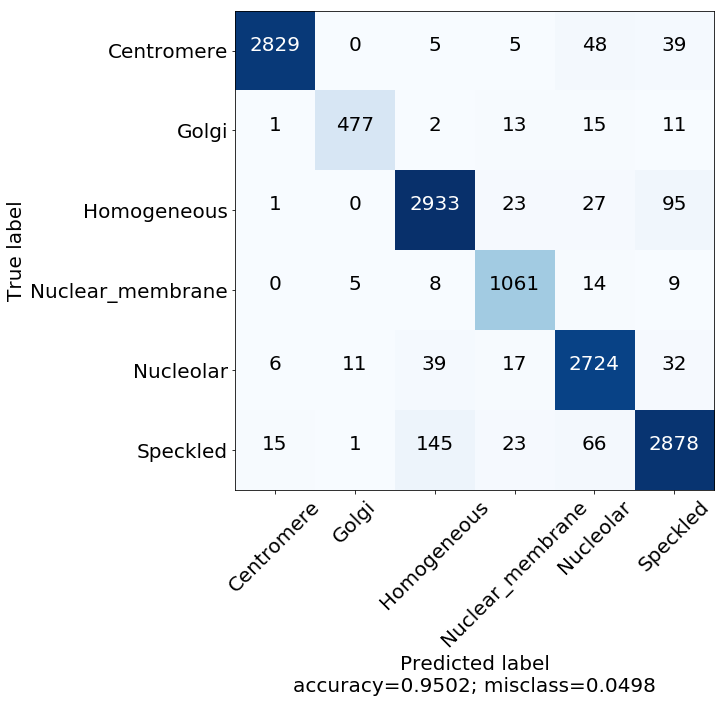

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2829    0    5    5   48   39]
 [   1  477    2   13   15   11]
 [   1    0 2933   23   27   95]
 [   0    5    8 1061   14    9]
 [   6   11   39   17 2724   32]
 [  15    1  145   23   66 2878]]
                  precision    recall  f1-score   support

      Centromere       0.99      0.97      0.98      2926
           Golgi       0.97      0.92      0.94       519
     Homogeneous       0.94      0.95      0.94      3079
Nuclear_membrane       0.93      0.97      0.95      1097
       Nucleolar       0.94      0.96      0.95      2829
        Speckled       0.94      0.92      0.93      3128

     avg / total       0.95      0.95      0.95     13578



In [23]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  99.96466431095406
Specificity :  100.0


In [24]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

ValueError: multiclass format is not supported

In [25]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported

In [26]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

13578/13578 [==============================] - 0s 18us/step


In [27]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: classes [0 1] missmatch with the labels [0 1 2 3 4 5]found in the data

In [28]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

KeyError: 0

In [29]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

KeyError: 'micro'

<Figure size 720x720 with 0 Axes>

In [30]:
tn, fp, fn, tp = cm.ravel()

ValueError: too many values to unpack (expected 4)

In [31]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

NameError: name 'tp' is not defined

In [32]:
print('F1 score:', f1_score(y_true, y_pred))

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [33]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

NameError: name 'tp' is not defined

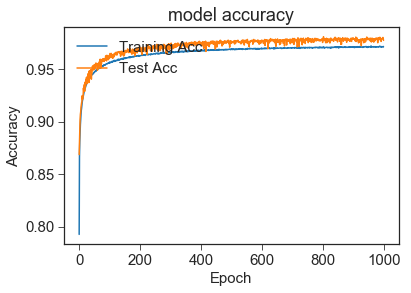

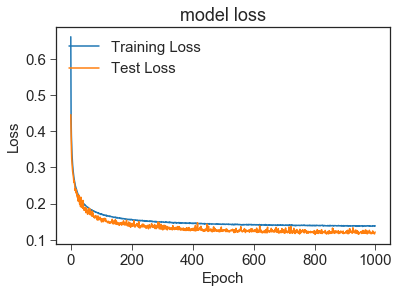

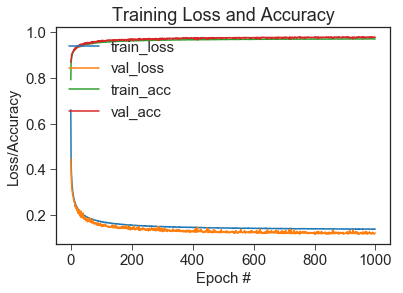

In [34]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")